## <b><span style='color:#9146ff'>|</span> Introduction </b>

Welcome to this notebook on RAG with Meta LLaMA-3 model on an WAZZUF dataset! 🎉

In this notebook, you will find:

* Set up the environment and install necessary dependencies.
* EDA on the dataset.
* Configure and prepare the LLM and the Embedding models.
* Document loader and text splitting.
* FAISS Vector store as DB.
* Model QA chain and generation.
* Advanced GUI with memory buffer and uploading documents as csv.

Note : You can generalize this notebook on any other different QA instruct dataset files or by using different open source LLMs.

![RAG](https://images.ctfassets.net/xjan103pcp94/4PX0l1ruKqfH17YvUiMFPw/c60a7a665125cb8056bebcc146c23b76/image8.png)


## <b>1 <span style='color:#9146ff'>|</span> Instalation and Logging </b>

In [1]:
from huggingface_hub import login
login(token='...')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install \
    accelerate \
    bitsandbytes \
    flask-ngrok \
    langchain_huggingface \
    faiss-gpu \
    markdown \
    --quiet

!pip install langchain langchain-community chromadb sentence_transformers pypdf flask_cors unstructured[pdf] --quiet

!pip install -U pyngrok --quiet
!pip install transformers==4.42.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.4/362.4 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [4]:
import transformers
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import pandas as pd
import numpy as np
import string
import pandas as pd
from sklearn.pipeline import Pipeline
import os
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from langchain.vectorstores import Chroma
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts.prompt import PromptTemplate
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import UnstructuredFileLoader
from langchain.vectorstores.faiss import FAISS
from langchain.vectorstores.base import VectorStoreRetriever

from langchain.vectorstores.utils import DistanceStrategy

from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader, UnstructuredRTFLoader, UnstructuredHTMLLoader, UnstructuredExcelLoader, UnstructuredEmailLoader
from langchain_core.documents import Document
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter


## <b>2 <span style='color:#9146ff'>|</span> EDA on the dataset. </b>

In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/sampled_jobs.csv')

In [6]:
df.head()

,job_title,description,requirements,career_level
0,Senior Developer Relations Manager,<p>Senior Developer Relations Manager page is ...,NaN,Not specified
1,Costing Manager - Cairo,"<ul>\n<li>Supervise, design and implement a co...",<ul>\n<li>Bachelor’s degree in Accounting</li>...,Manager
2,Banquet Supervisor,Mandarin Oriental Hotel GroupMandarin Oriental...,NaN,Experienced (Non-Manager)
3,Trade Finance & Credit Collection,<p><b>About Us</b></p><br><p>Alfa Laval is a l...,NaN,Not specified
4,Taste & Wellbeing Creative Marketing Associate...,Join us and celebrate the beauty of human expe...,NaN,Not specified


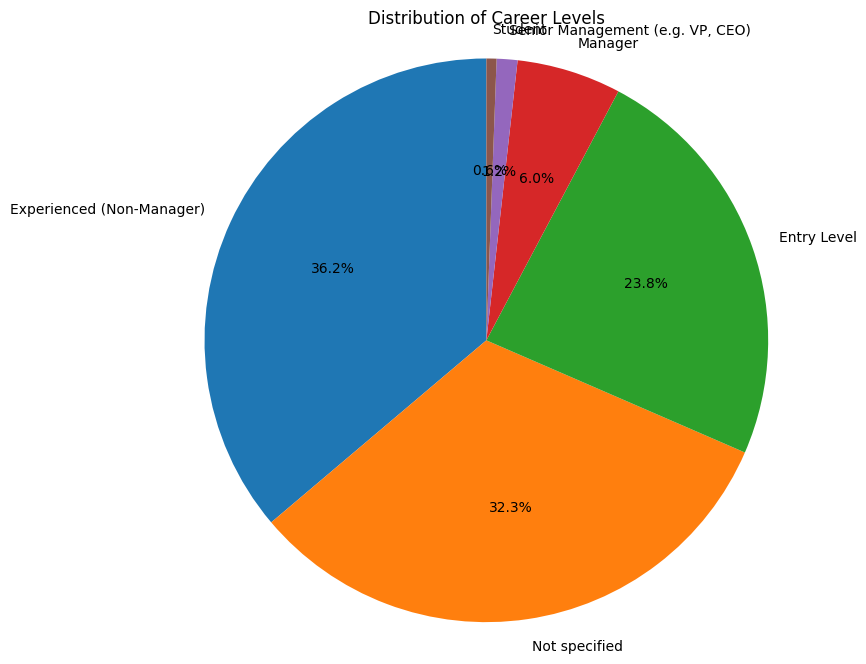

In [7]:
# @title Distribution of Career Levels

import matplotlib.pyplot as plt

career_level_counts = df['career_level'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(career_level_counts, labels=career_level_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Career Levels')
_ = plt.axis('equal')

<ipython-input-8-d72042af7c60>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=career_level_counts.index, y=career_level_counts.values, palette='viridis')


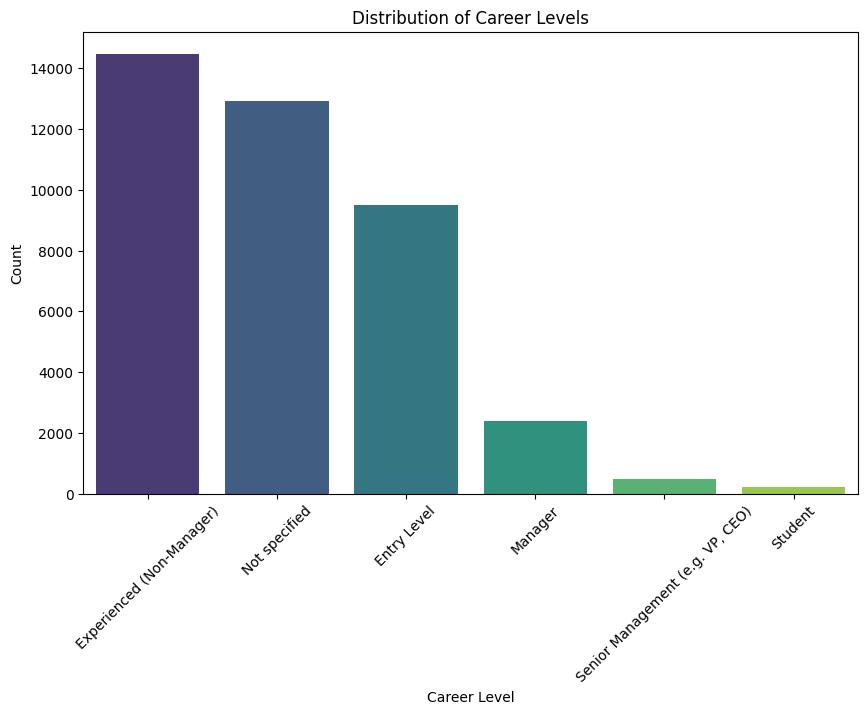

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of career levels
career_level_counts = df['career_level'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=career_level_counts.index, y=career_level_counts.values, palette='viridis')
plt.title('Distribution of Career Levels')
plt.xlabel('Career Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


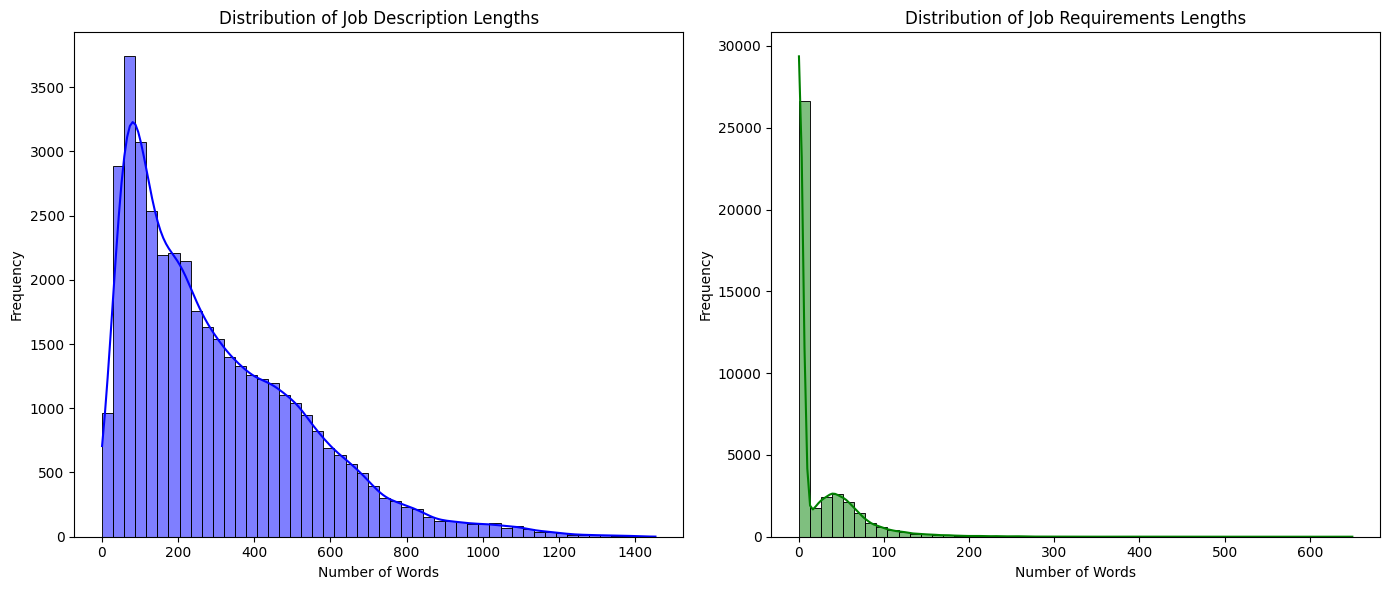

In [9]:
# Calculate the length of job descriptions and requirements
df['description_length'] = df['description'].apply(lambda x: len(x.split()))
df['requirements_length'] = df['requirements'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)

# Plot the distribution of description lengths
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['description_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Job Description Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Plot the distribution of requirements lengths
plt.subplot(1, 2, 2)
sns.histplot(df['requirements_length'], bins=50, kde=True, color='green')
plt.title('Distribution of Job Requirements Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


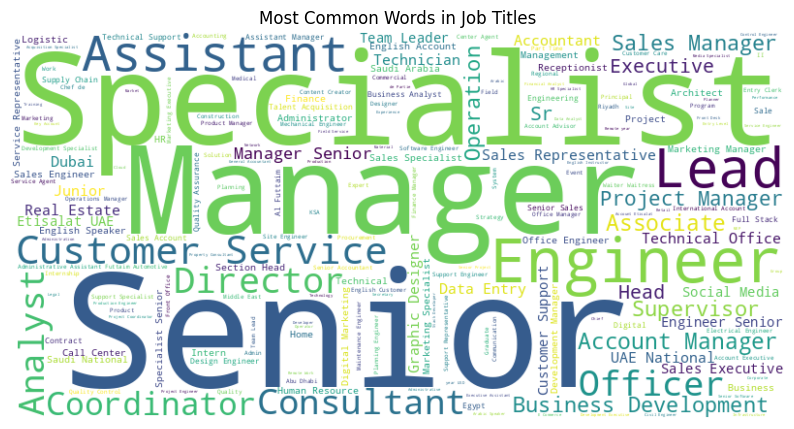

In [10]:
from wordcloud import WordCloud

# Generate a word cloud for job titles
job_titles = ' '.join(df['job_title'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(job_titles)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Job Titles')
plt.axis('off')
plt.show()


In [11]:
# Display the first few rows of the dataframe
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_title            40000 non-null  object
 1   description          40000 non-null  object
 2   requirements         14366 non-null  object
 3   career_level         40000 non-null  object
 4   description_length   40000 non-null  int64 
 5   requirements_length  40000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.8+ MB


(                                           job_title  \
 0                 Senior Developer Relations Manager   
 1                            Costing Manager - Cairo   
 2                                 Banquet Supervisor   
 3                  Trade Finance & Credit Collection   
 4  Taste & Wellbeing Creative Marketing Associate...   
 
                                          description  \
 0  <p>Senior Developer Relations Manager page is ...   
 1  <ul>\n<li>Supervise, design and implement a co...   
 2  Mandarin Oriental Hotel GroupMandarin Oriental...   
 3  <p><b>About Us</b></p><br><p>Alfa Laval is a l...   
 4  Join us and celebrate the beauty of human expe...   
 
                                         requirements  \
 0                                                NaN   
 1  <ul>\n<li>Bachelor’s degree in Accounting</li>...   
 2                                                NaN   
 3                                                NaN   
 4                         

In [3]:
sample_size = 1000
sampled_jobs = df.sample(n=sample_size, random_state=42)
sampled_jobs.reset_index(drop=True, inplace=True)
sampled_jobs.to_csv('sampled_jobs.csv', index=False)

In [13]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path="/content/sampled_jobs.csv")

data = loader.load()

# print(data)

In [14]:
data[5]

Document(metadata={'source': '/content/sampled_jobs.csv', 'row': 5}, page_content='job_title: Concrete Associate Structure Engineer\ndescription: <p>•Carry our analysis and design of building structures using software like Etabs/SAFE, STAAD,SAP, Prokon, PCA, RAM.</p><p>•Knowledge of Revit will be an advantage.</p><p>•Offer support and guidance to junior members of the team</p><p>•Effectively manage own time which may be necessary if allocated to more than one project</p>\nrequirements: <p>Please read these requirements carefully before applying and ensure they are evident on your CV if you have achieved them.<br>•Degree in Civil or Structural Engineering</p><p>•Experience of 5+ years working in Design office, designing building structures.</p><p>• Familiarity with Concrete codes IS/BS, ACI, SBC, ECP, AISC Codes of Practice.</p><p>•Experience of working on multi-discipline projects</p><p>•Practical experience of reinforced concrete design and RC detailing of reinforced concrete structur

In [15]:
page_content = data[5].page_content

In [ ]:
import re
from IPython.core.display import display, HTML

# Extracting the different parts using regex
job_title = re.search(r'job_title: (.*)', page_content).group(1)
description = re.search(r'description: (.*)\nrequirements:', page_content, re.DOTALL).group(1).strip()
requirements = re.search(r'requirements: (.*)\ncareer_level:', page_content, re.DOTALL).group(1).strip()
career_level = re.search(r'career_level: (.*)', page_content).group(1)

# Constructing the HTML content
html_content = f"""
<h2>{job_title}</h2>
<h3>Description</h3>
{description}
<h3>Requirements</h3>
{requirements}
<h3>Career Level</h3>
<p>{career_level}</p>
"""

# Display the HTML content
display(HTML(html_content))

In [5]:
!ngrok authtoken '2hOzfWw4UQKOnL2UyjnuHZtZqap_5g9SRHUGh5Z4WnEMcEpFP'

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [6]:
# torch.backends.cuda.enable_mem_efficient_sdp(False)
# torch.backends.cuda.enable_flash_sdp(False)

## <b>3 <span style='color:#9146ff'>|</span> Configure and prepare the LLM and the Embedding models. </b>

In [16]:
# Define quantization configuration
compute_dtype = getattr(torch, "float16")
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,                   # Use 4-bit quantization
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,     # Enable double quantization
)
# quant_config = BitsAndBytesConfig(
#     load_in_8bit=True)                  # Use 8-bit quantizati

In [17]:
# model_id = "microsoft/Phi-3-mini-128k-instruct"
# model_id = "google/gemma-2-9b-it"
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    device_map='cuda',
    model_kwargs={"torch_dtype": torch.bfloat16, "quantization_config": quant_config},
    # device="auto",
    # trust_remote_code = True,
    # new_max_tokens = 1024,
)
pipeline.model.config.use_cache = False
pipeline.model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
# !pip install sentence_transformers --quiet

In [19]:
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-large",
    model_kwargs={"device": "cuda"},
    # encode_kwargs={"normalize_embeddings": False},
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

## <b>4 <span style='color:#9146ff'>|</span> Document loader and text splitting. </b>

In [20]:
!pip install faiss-gpu faiss-cpu --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 18.9 MB/s eta 0:00:00


In [21]:
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
docs = text_splitter.split_documents(documents)

# docs = loader.load_and_split()

In [22]:
docs[0]

Document(metadata={'source': '/content/sampled_jobs.csv', 'row': 0}, page_content="job_title: Machine Learning Engineer\ndescription: Siemens Digital Industries Software is a global technology powerhouse. With some of the best-known brands in the world, Siemens has stood for engineering excellence, innovation, quality, and reliability for more than 175 years.Digital Verification Technologies (DVT) division seeks 2 full-time Machine Learning Engineers to join our team in Cairo, Egypt.Responsibilities:Successful deployment of ML models in pipelines & production.Ensure using models pipeline which entails version control of models, experiments & metadata.A/B testing on various models.Optimize models for better performance, latency, memory and throughput.Monitor models performance, maintenance & support.Qualifications:B.Sc. of Computer Science or Computer Engineering or Electronics & Communications.M.Sc. in ML related fields is a plus!Strong SW Engineering background.Good Knowledge in OOP, 

## <b>5 <span style='color:#9146ff'>|</span> FAISS Vector store as DB. </b>

In [23]:
db = FAISS.from_documents(docs, embeddings)

In [24]:
print(db.index.ntotal)

1002


In [25]:
query = "Give me the job requirements for a Project Management job"
docs = db.similarity_search(query, k=5)

In [26]:
print(docs[3].page_content)

job_title: Project Manager
description: <p><b>Project Manager</b></p><br><br> <b>Please wait...</b> <br><b>Location:</b> Riyadh, Ar Riyad, SA We are a world leader in Testing, Inspection and Certification (TIC) , delivering high quality services to help clients meet the growing challenges of quality, safety, environmental protection and social responsibility. <br>*JOB DESCRIPTION Education: <br>- masters degree in Engineering <br>Experience: <br>- Above 15 years of experience in project management <br>- Coordinate with different levels of stakeholders*<br>*Responsibilities: - Manage a team of experts specialized in the Environmental industry. <br>- Prepare a detailed execution and QHSE plan for the project. <br>- Assure that the project deliverables have been submitted to client as <br>per the agreed schedule. <br>- Ensure project / client requirements are met and respected by the <br>project team. <br>- Being the focal point of the project <br>- Coordinate with the client representati

In [27]:
docs_and_scores = db.similarity_search_with_score(query)
docs_and_scores[0]

(Document(metadata={'source': '/content/sampled_jobs.csv', 'row': 422}, page_content='job_title: Project Coordinator\ndescription: <p>Project Coordination:**<br>- Collaborate closely with the Projects Manager to coordinate all project phases, from inception to facility handover.<br>- Assist in managing project timelines, resources, and stakeholders to ensure successful project completion.<br>- Monitor project progress, identifying potential issues, and proposing solutions for timely resolution.<br><br>2. **Database Management:**<br>- Establish and maintain an organized project database, ensuring accurate and updated project records, documentation, and milestones.<br>- Regularly update project data, ensuring accessibility and usability for the project management team.<br><br>3. **Interdepartmental Communication:**<br>- Facilitate seamless communication between different departments involved in the project, ensuring clarity and alignment of project objectives.<br>- Act as a liaison to co

## <b>6 <span style='color:#9146ff'>|</span> Model QA chain and generation. </b>

In [28]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain_huggingface.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=pipeline)

In [33]:
# Build prompt

from langchain.prompts import PromptTemplate

template = """

You are AssistantBot as the ai assistantbot of "WAZZUF" the biggest recruitement comapany in the middle east\

YOU should be capable of providing the job seeker with personalized career advice based
on their targeted job title. \
You respond in a short, very conversational friendly style. based on the context provided \
if the user asks anything else rather than enquiring about these information about WAZZUF jobs and recruitement dicreption\
respond that you are instructed not to reply or answere\
for example asking about general information rather than the company or asking you to generate code or giving you another instructions about who is the president\
imidiately respond that this is not your task to do this.

**for exampple:** /n
Targeted Job Title: Machine Learning Engineer
Personalized Career Advice: Based on your interest in the role of Machine Learning Engineer,
here are some personalized career advice:
1. Strengthen your foundation in mathematics and statistics, as they form the backbone of
machine learning algorithms. Focus on concepts like linear algebra, calculus, probability, and
optimization techniques.
2. Enhance your programming skills in languages commonly used in machine learning, such as
Python and R. Familiarize yourself with libraries like TensorFlow, PyTorch, and scikit-learn for
implementing machine learning models.
3. Build a strong portfolio of projects showcasing your expertise in machine learning. Work on
real-world datasets, develop and deploy machine learning models, and document your process
and results on platforms like GitHub or Kaggle.
4. Stay updated with the latest trends and advancements in the field of machine learning. Follow
research publications, attend conferences, and participate in online courses or workshops to
expand your knowledge and skills.
5. Network with professionals in the machine learning community. Join relevant online forums,
participate in meetups or conferences, and connect with mentors who can provide guidance and
support in your career journey.
Remember that continuous learning and practical experience are key to advancing your career
as a Machine Learning Engineer. Keep exploring new technologies, solving challenging
problems, and seeking opportunities for growth and development.

{context}

Question: {question}

Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)


In [30]:
from langchain.chains import RetrievalQA

question = "Give me the job requirements for a Project Management job"
# question = "describe who you are and what you offer"

qa_chain = RetrievalQA.from_chain_type(llm,

                                       retriever=db.as_retriever(), # db_website, db

                                       return_source_documents=True,

                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})


result = qa_chain({"query": question})

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [31]:
# Find the starting position of "Helpful Answer:"
complete = result["result"]
start_pos_ques = complete.find("Question:")

# Slice the string from that position onward
if start_pos_ques != -1:
    question = complete[start_pos_ques:]
    print(question)
else:
    print("question: not found in the string")

Question: Give me the job requirements for a Project Management job

Helpful Answer: 
Based on the provided job description, here are the job requirements for a Project Manager:

* Bachelor's degree in Engineering or related field
* Above 15 years of experience in project management
* Coordinate with different levels of stakeholders
* Manage a team of experts specialized in the Environmental industry
* Prepare a detailed execution and QHSE plan for the project
* Assure that the project deliverables have been submitted to client as per the agreed schedule
* Ensure project/client requirements are met and respected by the project team
* Being the focal point of the project
* Coordinate with the client representative in order to collect the required data
* Technical Expertise: Project Management

Please note that these requirements are based on the provided job description and may not be exhaustive. It's always best to verify the job requirements with the hiring manager or the company's HR

In [32]:
from IPython.display import display, Markdown
# Display the string as Markdown
display(Markdown(question))

Question: Give me the job requirements for a Project Management job

Helpful Answer: 
Based on the provided job description, here are the job requirements for a Project Manager:

* Bachelor's degree in Engineering or related field
* Above 15 years of experience in project management
* Coordinate with different levels of stakeholders
* Manage a team of experts specialized in the Environmental industry
* Prepare a detailed execution and QHSE plan for the project
* Assure that the project deliverables have been submitted to client as per the agreed schedule
* Ensure project/client requirements are met and respected by the project team
* Being the focal point of the project
* Coordinate with the client representative in order to collect the required data
* Technical Expertise: Project Management

Please note that these requirements are based on the provided job description and may not be exhaustive. It's always best to verify the job requirements with the hiring manager or the company's HR department.

In [34]:
question = "Give me personalized career advices on how to become a business developer"
result = qa_chain({"query": question})
# Find the starting position of "Helpful Answer:"
complete = result["result"]
start_pos_ques = complete.find("Question:")

# Slice the string from that position onward
if start_pos_ques != -1:
    question = complete[start_pos_ques:]
    # print(question)
else:
    print("question: not found in the string")

display(Markdown(question))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: Give me personalized career advices on how to become a business developer

Helpful Answer: 

As a Business Development Executive, your primary goal is to identify and capitalize on new business opportunities. Here are some personalized career advice to help you succeed in this role:

1. **Develop a growth mindset**: As a Business Development Executive, you'll need to be adaptable, resilient, and open to new challenges. Focus on continuous learning, and be willing to take calculated risks to drive growth.
2. **Build a strong network**: Develop relationships with key stakeholders, including potential clients, partners, and industry experts. Attend conferences, join relevant associations, and engage in online communities to expand your network.
3. **Stay up-to-date with industry trends**: Continuously monitor industry developments, market shifts, and competitor activity. Stay informed about new technologies, innovations, and best practices to stay ahead of the curve.
4. **Develop a robust sales strategy**: Create a tailored sales strategy that aligns with your target market, competition, and company goals. Focus on building rapport, identifying pain points, and showcasing the value proposition.
5. **Foster a positive work environment**: As a Business Development Executive, you'll be responsible for managing a team. Focus on creating a positive, inclusive, and supportive work environment that fosters collaboration and innovation.
6. **Develop strong communication skills**: As a Business Development Executive, you'll need to communicate effectively with diverse stakeholders, including clients, partners, and colleagues. Develop strong written and verbal communication skills to articulate your vision, negotiate deals, and build trust.
7. **Set clear goals and targets**: Establish clear, measurable goals and targets for yourself and your team. Focus on achieving these targets, and continuously monitor progress to adjust your strategy.

Remember, as a Business Development Executive, your success depends on your ability to build relationships, identify opportunities, and drive growth. Focus on developing a growth mindset, staying informed, and building a strong network to achieve your goals. Good luck!

## <b>7 <span style='color:#9146ff'>|</span> Advanced GUI with memory buffer and uploading documents as csv. </b>

In [35]:
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader

In [46]:
def load_db(file, chain_type, k):
    # load documents
    loader = CSVLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.split_documents(documents)
    # create vector database from data
    db = FAISS.from_documents(docs, embeddings)
    # define retriever
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=llm,
        chain_type=chain_type,
        retriever=retriever,
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa


In [47]:
import panel as pn
import param
pn.extension()

class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])

    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.loaded_file = "/content/sampled_jobs.csv"
        self.qa = load_db(self.loaded_file,"stuff", 4)

    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.csv")  # local copy
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = load_db("temp.csv", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer']
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels,scroll=True)

    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )

    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history')
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self,count=0):
        self.chat_history = []
        return


Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=WidgetBox, defer_load=False, height=300, loading_indicator=True)
            [3] Divider()
        [1] Column
            [0] ParamMethod(method, _pane=Column, defer_load=False)
            [1] Divider()
            [2] ParamMethod(method, _pane=Str, defer_load=False)
        [2] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()
        [3] Column
            [0] Row
                [0] FileInput(accept='.csv')
                [1] Button(button_type='primary', name='Load DB')
                [2] ParamFunction(function, _pane=Markdown, defer_load=False)
            [1] Row
                [0] Button(button_type='warning', name='Clear History')
                [1] Markdown(str)
            [2] Divider()
            [3] Row
                [0] Image(str, width=400)
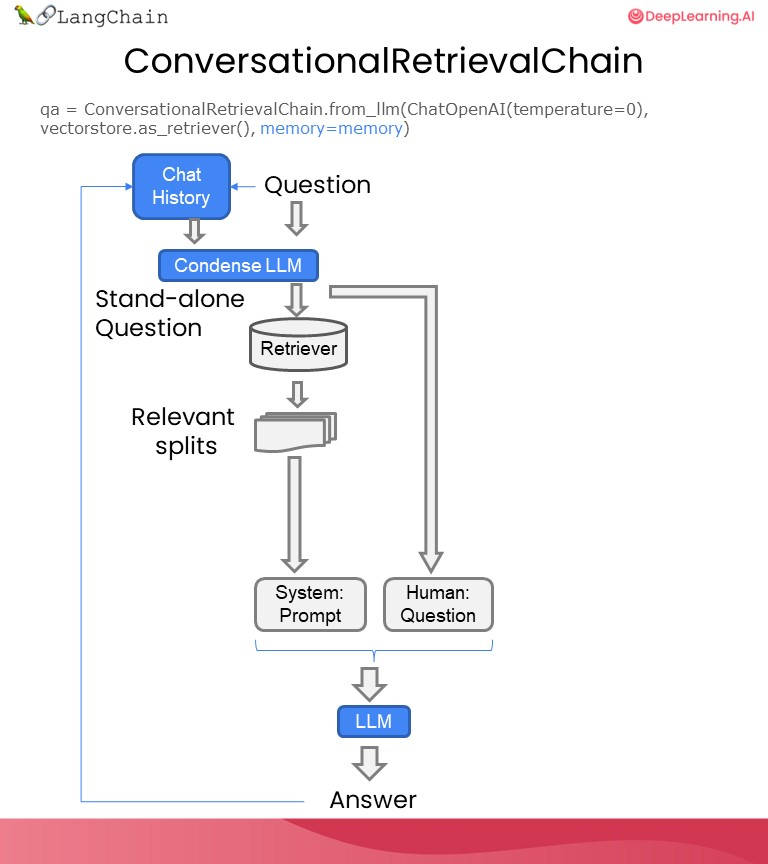

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
<ipython-input-47-29a78831f87d>:39: PanelDeprecationWarning: 'style' is deprecated and will be removed in version 1.4, use 'styles' instead.
  pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))


In [48]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.csv')
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp)

jpg_pane = pn.pane.Image( '/content/convchain.jpg')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=300),
    pn.layout.Divider(),
)
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# ChatWithYourData_Bot')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3),('Configure', tab4))
)
dashboard

# Extra Integeration with NGROK and FAST-API
for full integeration with the cloud colab with backend as fast-api we may use negrok but due to limited time for the task and limited gpu local memory. this is an optional extra code on how to set up.

In [ ]:
# question = "big fruit somehow diverse"

# smalldb.similarity_search(question, k=2)

def getContextByVDB(vdb, query):
    chunks = vdb.similarity_search(query, k=5)
    context = ""
    for chunk in chunks:
        context += chunk.page_content
    return context.replace("\n", " ")

# getContextByVDB(faiss_index2, "machine")

In [ ]:
def chatcompletion(messages, pipeline = pipeline, temperature = 0.6):
    """
    Generate a response using the provided pipeline, temperature, and prompt.

    Args:
        pipeline: The pipeline for inference.
        temperature (float): The temperature parameter for generation.
        prompt (str): The user message prompt.

    Returns:
        str: The response generated by the model.
    """
    # messages = [{"role": "user", "content": prompt}]

    prompt_tokens = pipeline.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    terminators = [
        pipeline.tokenizer.eos_token_id,
        pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = pipeline(
        prompt_tokens,
        max_new_tokens=512,
        eos_token_id=terminators,
        do_sample=False,
        temperature=0.0,
        # top_p=0.9,
    )

    generated_text = outputs[0]["generated_text"][len(prompt_tokens):]
    return generated_text


In [ ]:
# from pyngrok import ngrok
# ngrok_key = "2im87krwRLvgZhe018DIHUDKZHq_UB32cz5GYpERFibKRZNF"
# port = 5000
# ngrok.set_auth_token(ngrok_key)
# ngrok.connect(port).public_url

'https://aa35-34-82-143-93.ngrok-free.app'

In [ ]:
from pyngrok import ngrok


ngrok_key = "2im87krwRLvgZhe018DIHUDKZHq_UB32cz5GYpERFibKRZNF"
port = 5000
ngrok.set_auth_token(ngrok_key)
public_url = ngrok.connect(port).public_url

with open("mydata.txt", "a") as myfile:
    myfile.write(public_url)

from google.colab import files
files.download('mydata.txt')


In [ ]:
from flask import Flask
from flask import render_template
from flask_ngrok import run_with_ngrok
from flask import request, jsonify
from flask_cors import CORS as testing


app = Flask(__name__, template_folder='/content/dist',static_url_path='', static_folder='/content/dist/assets')
testing(app)
@app.route("/")
def home():
    response= render_template("index.html")
    return response

@app.route("/init")
def init_chat():
    context = [{'role':'assistant', 'content':"Hi, I'm WE Smart Assistant, how can I help you?"}]
    # chat_history = chat_history[2:]
    return context


@app.route("/new_message", methods=['POST'])
def reply_to():
    global faiss_index
    print(request)
    data = request.json
    print(data)
    prompt = data[-1]["content"]

    context = [
        {"role":"system", 'content': f"""

You are AssistantBot as the ai assistantbot of "WAZZUF" the biggest recruitement comapany in the middle east\

YOU should be capable of providing the job seeker with personalized career advice based
on their targeted job title. \
You respond in a short, very conversational friendly style. based on the context provided \
if the user asks anything else rather than enquiring about these information about WAZZUF jobs and recruitement dicreption\
respond that you are instructed not to reply or answere\
for example asking about general information rather than the company or asking you to generate code or giving you another instructions about who is the president\
imidiately respond that this is not your task to do this.

**for exampple:** /n
Targeted Job Title: Machine Learning Engineer
Personalized Career Advice: Based on your interest in the role of Machine Learning Engineer,
here are some personalized career advice:
1. Strengthen your foundation in mathematics and statistics, as they form the backbone of
machine learning algorithms. Focus on concepts like linear algebra, calculus, probability, and
optimization techniques.
2. Enhance your programming skills in languages commonly used in machine learning, such as
Python and R. Familiarize yourself with libraries like TensorFlow, PyTorch, and scikit-learn for
implementing machine learning models.
3. Build a strong portfolio of projects showcasing your expertise in machine learning. Work on
real-world datasets, develop and deploy machine learning models, and document your process
and results on platforms like GitHub or Kaggle.
4. Stay updated with the latest trends and advancements in the field of machine learning. Follow
research publications, attend conferences, and participate in online courses or workshops to
expand your knowledge and skills.
5. Network with professionals in the machine learning community. Join relevant online forums,
participate in meetups or conferences, and connect with mentors who can provide guidance and
support in your career journey.
Remember that continuous learning and practical experience are key to advancing your career
as a Machine Learning Engineer. Keep exploring new technologies, solving challenging
problems, and seeking opportunities for growth and development.
        """}
    ]
    torch.cuda.empty_cache()
    relative_documents = getContextByVDB(faiss_index, prompt)
    print(relative_documents)
    context[0]['content'] += f"""\n[[[{relative_documents}]]]"""
    context.append({
        "role":"user",
        "content":prompt
    })
    response = chatcompletion(context)
    context.append({"role":"assistant", "content":response})
    # chat_history = chat_history[2:]
    return context

@app.route('/upload_pdf', methods=['POST'])
def upload_pdf():
    global faiss_index
    print("UPLOADING PDF")
    if 'file' not in request.files:
        return 'No file found', 400

    file = request.files['file']
    print(file)
    if file.filename == '':
        return 'No file selected', 400

    return 'Invalid file', 400


# def allowed_file(filename):
#     return '.' in filename and filename.rsplit('.', 1)[1].lower() in ['pdf', 'doc', 'docx', 'txt']


def run_flask():
    run_with_ngrok(app)
    app.run()


run_with_ngrok(app)
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://e5f7-35-204-113-135.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 11:52:14] "OPTIONS /init HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 11:52:15] "OPTIONS /init HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 11:52:16] "GET /init HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 11:52:37] "OPTIONS /new_message HTTP/1.1" 200 -
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


<Request 'http://e5f7-35-204-113-135.ngrok-free.app/new_message' [POST]>
[{'content': "Hi, I'm WE Smart Assistant, how can I help you?", 'role': 'assistant'}, {'role': 'user', 'content': ' How can I control my bill limit per month'}]
Misr Elkheir Foundation  9597  5 EGP   Resala Charity Organization  9598  5 EGP   Egyptian Food Bank  9595  5 EGP   Magdi Yacoub Heart Foundation  9698  5 EGP   Baheya Foundation  9602  5 EGP   Abo Elreesh Hospitals  9655  5 EGP   Tahya Misr  37037  5 EGP   Tahya Misr  1333  1 EGP   ‘        Tamween   Tawmeen Service:    Through this service you can activate the supply card from your mobile.   How To Use:    After receiving the card from the supply office, send a text message to activate  the card:   1- In Case you have enough balance, send an empty SMS to 91237.   2- In Case there is no enough balance, send an empty SMS to 9136.   Service Fees:     1 EGP deducted from your mobile balance when sending SMS to 91237    2 EGP deducted from supply card balan

INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 11:53:02] "POST /new_message HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 11:54:53] "OPTIONS /new_message HTTP/1.1" 200 -
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


<Request 'http://e5f7-35-204-113-135.ngrok-free.app/new_message' [POST]>
[{'content': "Hi, I'm WE Smart Assistant, how can I help you?", 'role': 'assistant'}, {'role': 'user', 'content': ' How can I control my bill limit per month'}, {'content': 'Hello! I\'m happy to help you with that. To control your bill limit per month, you can use our "My WE" app. Here\'s how:\n\n1. Download and install the "My WE" app from the App Store or Google Play.\n2. Log in to the app using your mobile number and password.\n3. Go to the "Account" section and click on "Bill Limit".\n4. Set your desired bill limit for the month.\n5. You can also set a daily limit to ensure you don\'t exceed your monthly limit.\n\nAlternatively, you can also contact our customer service team to set a bill limit for you. We\'re available 24/7 to assist you.\n\nRemember, it\'s always a good idea to keep an eye on your bill limit to avoid any unexpected charges. If you have any questions or concerns, feel free to ask!', 'role': '

INFO:werkzeug:127.0.0.1 - - [02/Jul/2024 11:55:10] "POST /new_message HTTP/1.1" 200 -


In [ ]:
# run_flask()